In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, concatenate
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow import keras

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate

from keras.datasets import cifar10
import string
import csv

In [2]:
data_dir = 'C:/Users/Hp/Desktop/Traffic-Sign-Recognisation-Using-Deep-Learning-master/'
train_path = 'C:/Users/Hp/Desktop/Traffic-Sign-Recognisation-Using-Deep-Learning-master/Train'
test_path = 'C:/Users/Hp/Desktop/Traffic-Sign-Recognisation-Using-Deep-Learning-master/Test'

In [3]:
n = pd.read_csv(data_dir + '/Train.csv')
n_classes = len(set(n['ClassId'].values))
print(f"Number of classes: {n_classes}")

Number of classes: 43


In [4]:
# Labels Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing Dataset

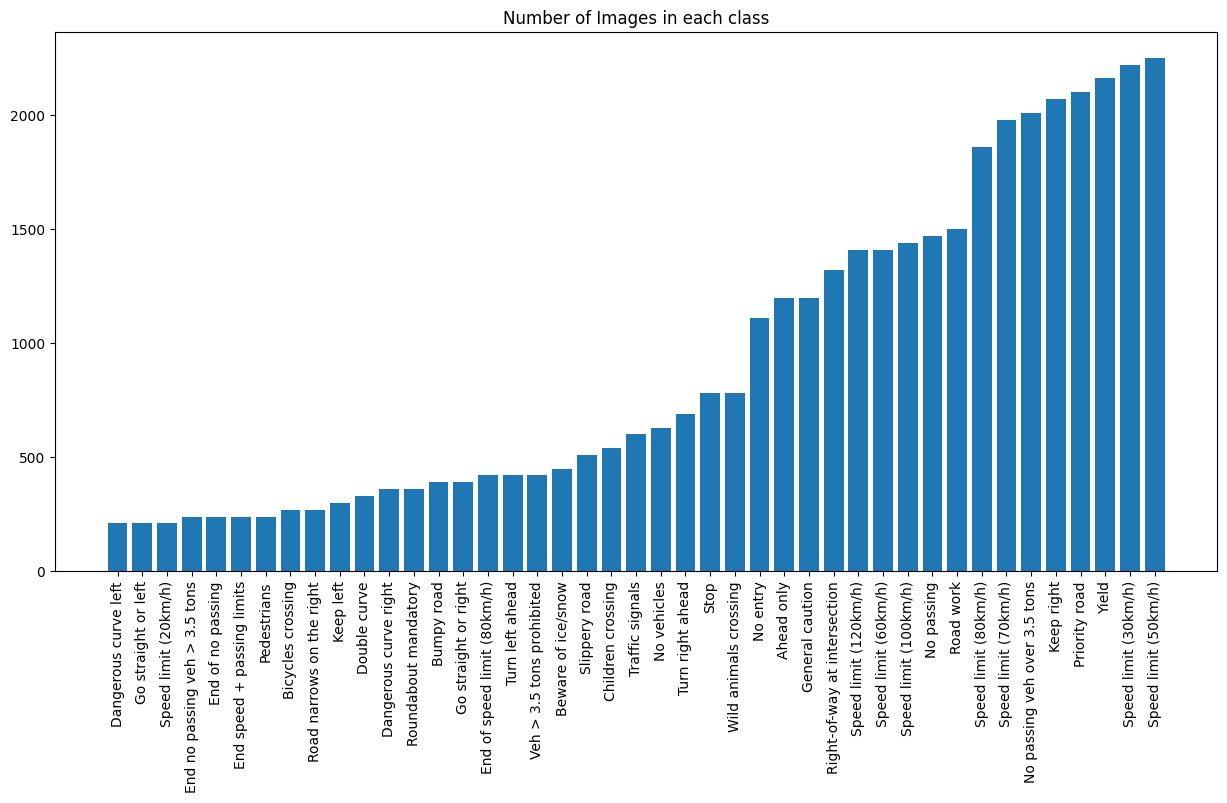

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(15,7))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.title("Number of Images in each class")
plt.show()

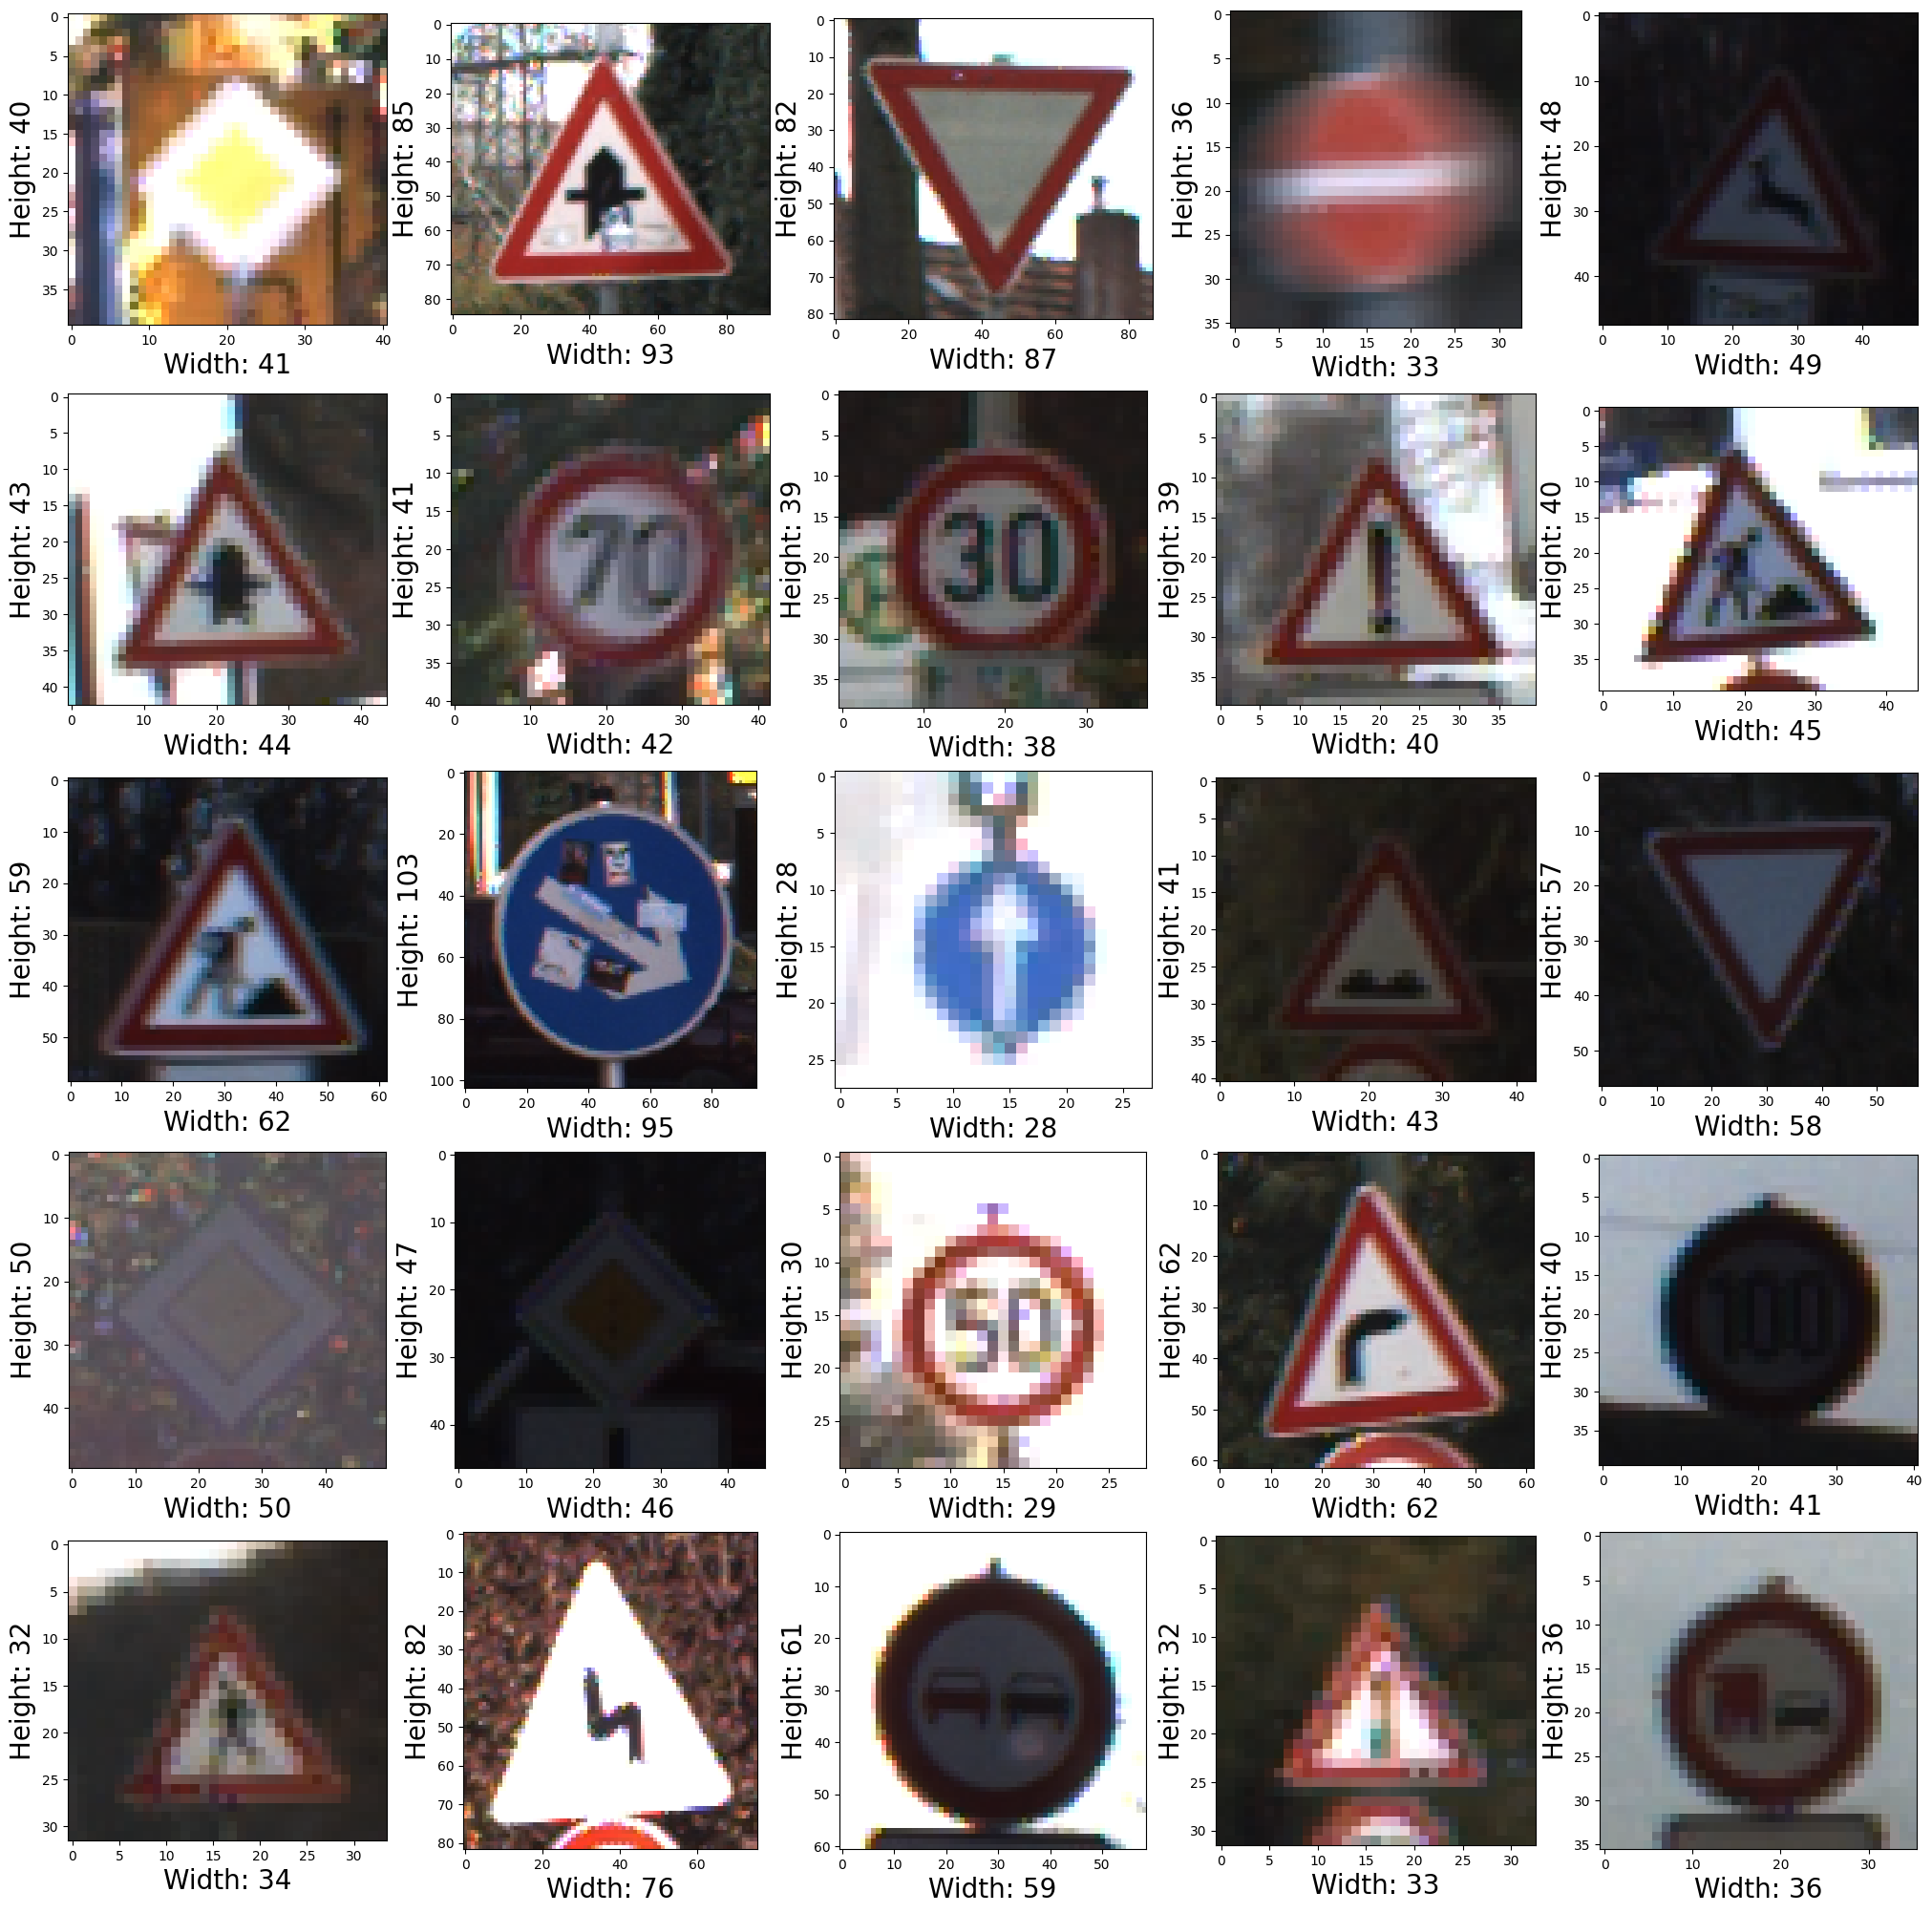

In [6]:
import random
from matplotlib.image import imread
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values
plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    
    # Randomly choose an image path
    random_img_path = np.random.choice(imgs)
    
    # Construct the full path using os.path.join
    random_img_path = os.path.join(data_dir, random_img_path)
    
    # Attempt to read the image
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=False)
    plt.xlabel("Width: {}".format(rand_img.shape[1]), fontsize=20)
    plt.ylabel("Height: {}".format(rand_img.shape[0]), fontsize=20)


## Creating Dataset

In [7]:
data = []
labels = []

for i in range(n_classes):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
      image = cv2.imread(path + '/' + img)
      rz = cv2.resize(image, (32,32), interpolation = cv2.INTER_NEAREST)
      data.append(np.array(rz))
      labels.append(i)

data = np.array(data)
labels = np.array(labels)
print(f"data shape: {data.shape}")
print(f"labels shape: {labels.shape}")

data shape: (39209, 32, 32, 3)
labels shape: (39209,)


(32, 32, 3)


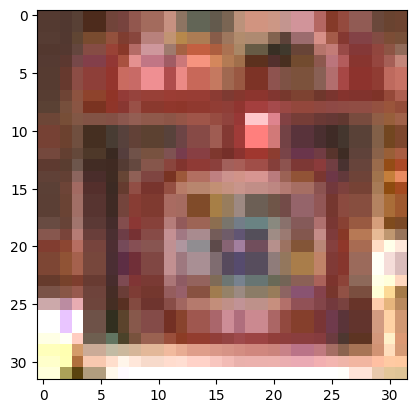

1


In [8]:
#Random Image from data set
print(data[300].shape)
img = cv2.cvtColor(data[300], cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print(labels[300])

In [9]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=41, shuffle=True)

X_train = X_train/255     # Normalizing Values
X_val = X_val/255         # Normalizing Values
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [10]:
y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

y_train.shape (31367, 43)
y_valid.shape (7842, 43)


## Model Architecture

In [11]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [12]:
def GoogLeNet(X):
  # input layer 
  input_layer = Input(shape = (X.shape[1], X.shape[2], X.shape[3]))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (3,3), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2, padding='same')(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)
  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  #X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  #X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)
  
  # 7th Inception block
  #X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D()(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(43, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, X, name = 'GoogLeNet')

  return model

model_google = GoogLeNet(X_train)
model_google.summary()



Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 15, 15, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 15, 15, 96)           6240      ['conv2d[0][0]']              
                                                                                                  
 conv2d_4 (Conv2D)           (None, 15, 15, 16)           1040      ['conv2d[0][0]']              
                                                                                        

## Visualizing Model

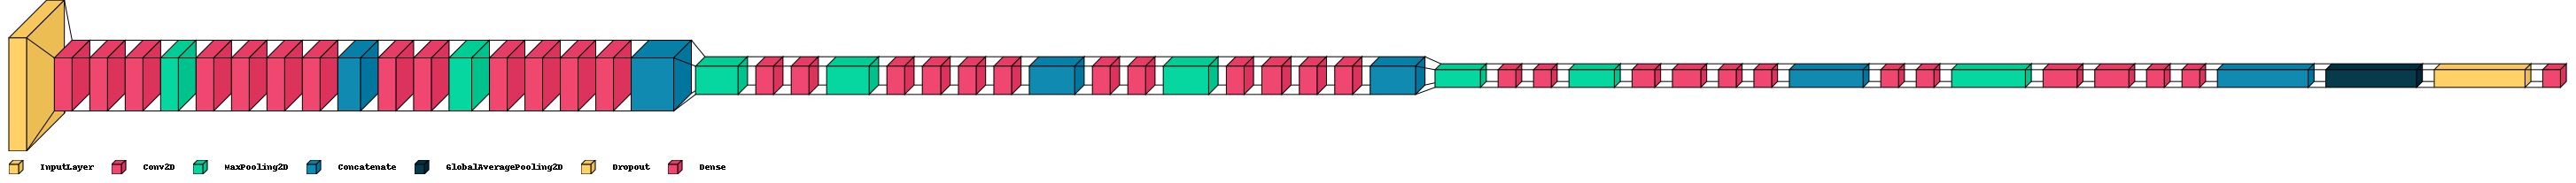

In [ ]:
import visualkeras
visualkeras.layered_view(model_google, legend=True, spacing=20)

## Training

In [13]:
# Parameters
bs = 128
ep = 15
lr = 0.0001

opt = Adam(learning_rate=lr)
model_google.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Augmenting Training Data
data_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history_google = model_google.fit(data_gen.flow(X_train, y_train, batch_size=bs), epochs=ep, validation_data=(X_val, y_val))

Epoch 1/15


246/246 [==============================] - 1231s 5s/step - loss: 3.3059 - accuracy: 0.1032 - val_loss: 2.7379 - val_accuracy: 0.2209
Epoch 2/15
246/246 [==============================] - 1136s 5s/step - loss: 2.4258 - accuracy: 0.2715 - val_loss: 1.8751 - val_accuracy: 0.4096
Epoch 3/15
246/246 [==============================] - 1110s 5s/step - loss: 1.8324 - accuracy: 0.4049 - val_loss: 1.4786 - val_accuracy: 0.4948
Epoch 4/15
246/246 [==============================] - 1108s 5s/step - loss: 1.4534 - accuracy: 0.5073 - val_loss: 1.1532 - val_accuracy: 0.6004
Epoch 5/15
246/246 [==============================] - 1152s 5s/step - loss: 1.1451 - accuracy: 0.6083 - val_loss: 0.8288 - val_accuracy: 0.7126
Epoch 6/15
246/246 [==============================] - 1101s 4s/step - loss: 0.9085 - accuracy: 0.6879 - val_loss: 0.6371 - val_accuracy: 0.7849
Epoch 7/15
246/246 [==============================] - 1050s 4s/step - loss: 0.6730 - accuracy: 0.7709 - val_loss: 0.4597 - val_accurac

In [16]:
model_google.save('GoogleNet.h5')

In [17]:
reconstructed_model = keras.models.load_model("GoogleNet.h5")


## Evaluating Model

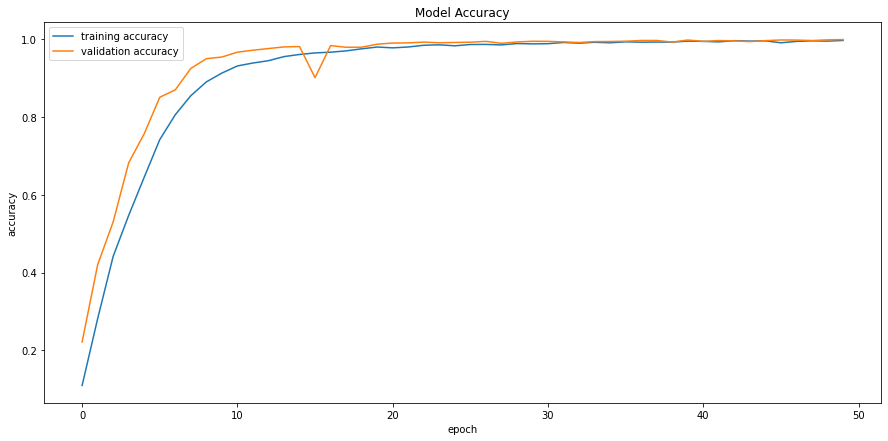

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history_google.history['accuracy'])
plt.plot(history_google.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
plt.show()

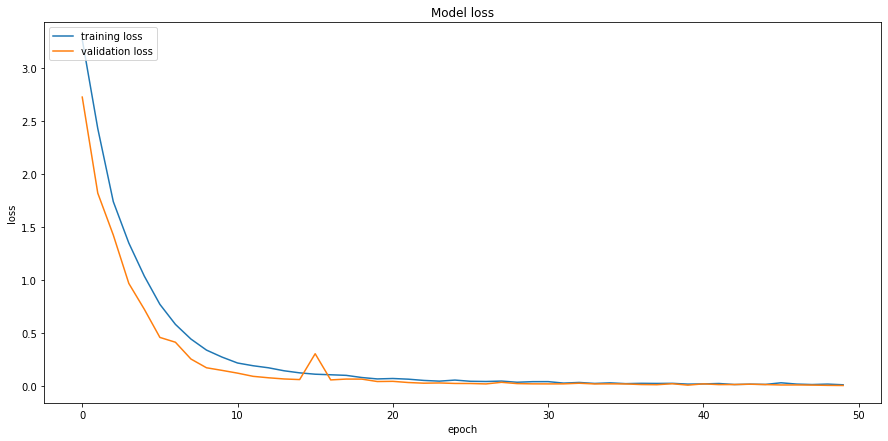

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history_google.history['loss'])
plt.plot(history_google.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

test_labels = test["ClassId"].values
test_imgs = test["Path"].values
print(len(test_imgs))
test_data =[]

for img in test_imgs:
  image = cv2.imread(data_dir+'/'+img)
  rz = cv2.resize(image, (32, 32), interpolation = cv2.INTER_NEAREST)
  test_data.append(rz)

X_test = np.array(test_data)
X_test = X_test/255         # Normalizing Values

print("X_test.shape", X_test.shape)

12630
X_test.shape (12630, 32, 32, 3)


In [ ]:
from sklearn.metrics import accuracy_score
pred = model_google.predict(X_test)
pred_classes=np.argmax(pred, axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred_classes)*100)

Test Data accuracy:  96.24703087885986


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.95      0.99      0.97       720
           2       0.97      0.99      0.98       750
           3       0.98      0.96      0.97       450
           4       1.00      0.93      0.96       660
           5       0.96      0.98      0.97       630
           6       0.99      0.98      0.99       150
           7       1.00      0.94      0.97       450
           8       0.95      1.00      0.97       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.96      0.91      0.93       420
          12       0.99      0.93      0.96       690
          13       0.93      1.00      0.97       720
          14       1.00      1.00      1.00       270
          15       0.98      0.99      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predicting

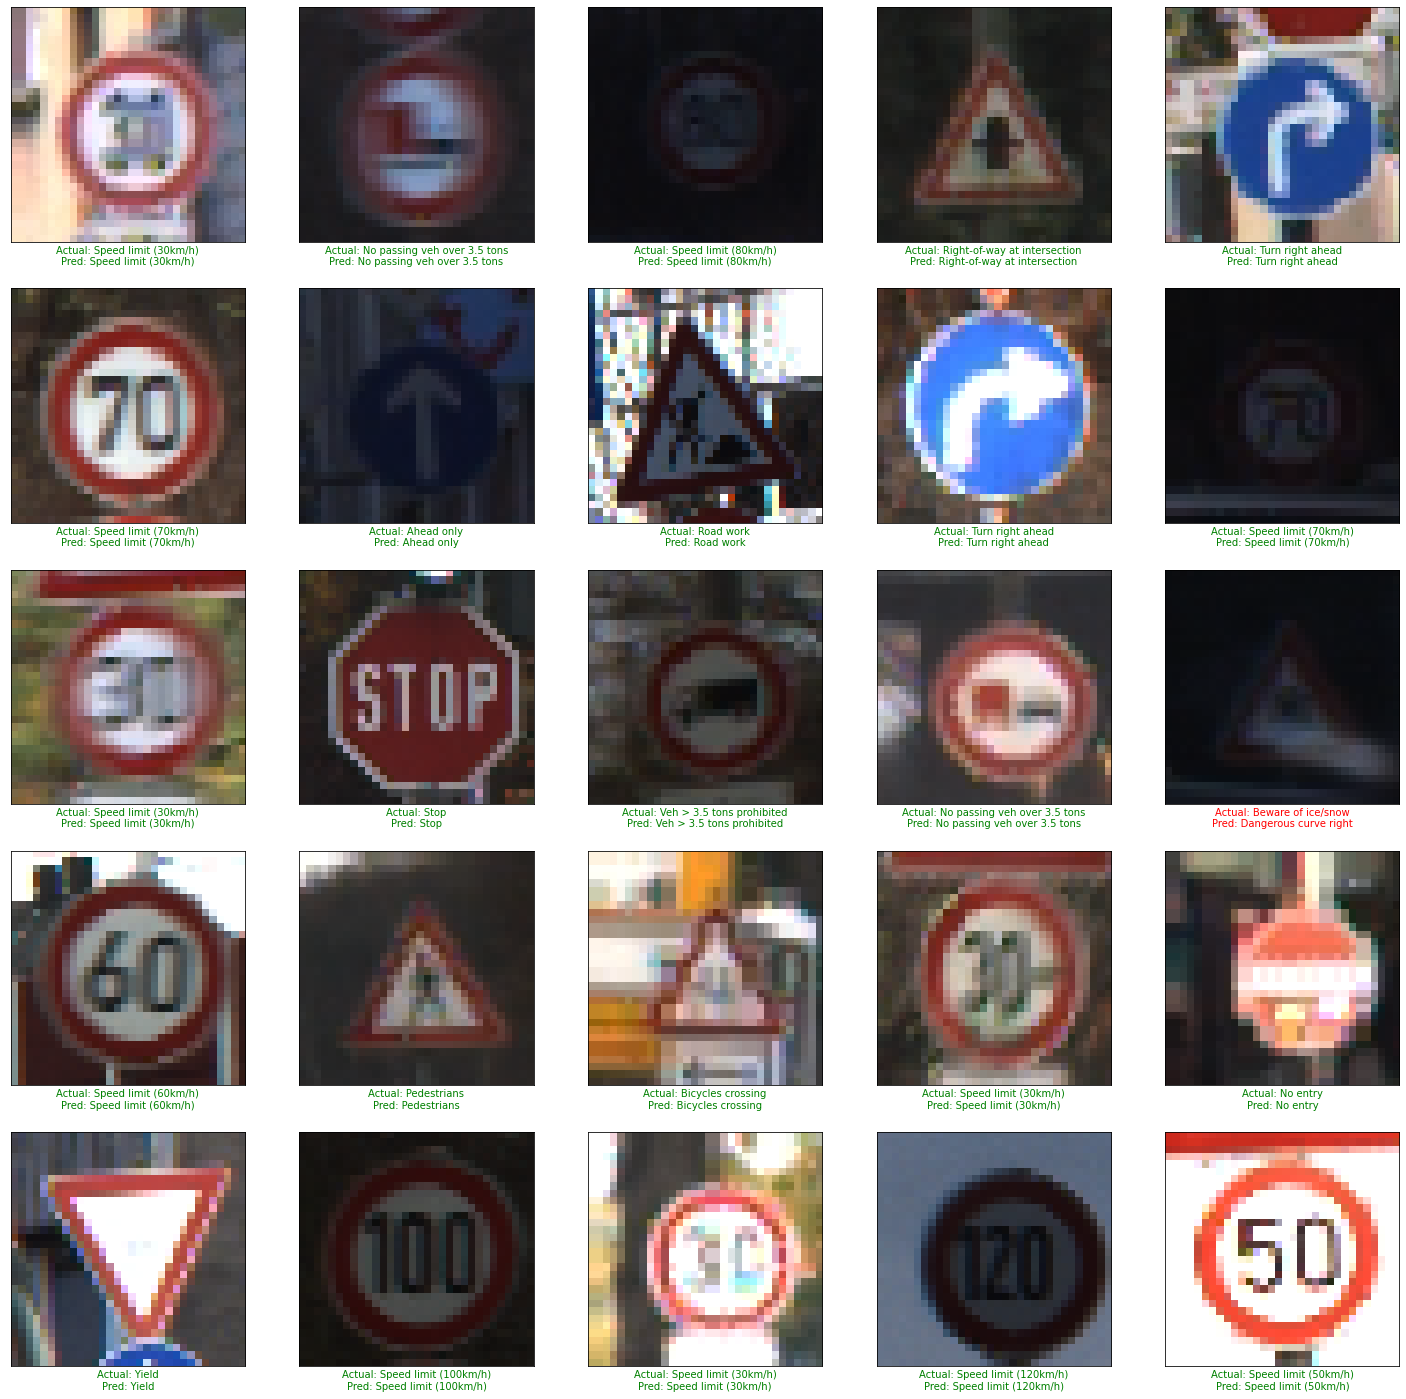

In [ ]:
plt.figure(figsize = (25, 25))

start_idx = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[start_idx + i + 100]
    actual = test_labels[start_idx + i + 100]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.imshow(cv2.cvtColor(np.array(X_test[start_idx + i + 100], dtype=np.float32), cv2.COLOR_BGR2RGB))
    plt.xlabel(f'Actual: {classes.get(actual)}''\n'f'Pred: {classes.get(prediction)}', color = col)
plt.show()